# Twitter Sentiment Analysis - Adversarial Testing

This notebook conducts comprehensive adversarial robustness testing for the Twitter sentiment analysis models.

## Objectives
1. **Adversarial Example Generation**: Create various types of adversarial examples
2. **Robustness Testing**: Test model resilience against attacks
3. **Defense Mechanisms**: Implement and evaluate defense strategies
4. **Performance Analysis**: Measure adversarial accuracy and robustness
5. **Security Assessment**: Identify vulnerabilities and security risks

## Adversarial Attack Types
1. **Character-level attacks**: Character substitutions, insertions, deletions
2. **Word-level attacks**: Synonym replacement, word order changes
3. **Paraphrase attacks**: Semantic-preserving text transformations
4. **Evasion attacks**: Input perturbations to fool models
5. **Data poisoning**: Training data contamination

## Defense Mechanisms
1. **Adversarial Training**: Train models on adversarial examples
2. **Input Sanitization**: Clean and validate inputs
3. **Ensemble Methods**: Use multiple models for robust predictions
4. **Detection Systems**: Identify adversarial inputs

## Target Metrics
- **Adversarial Accuracy**: > 75% under attack
- **Robustness Score**: Measure of model stability
- **Attack Success Rate**: Percentage of successful attacks


In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
import random
import string
import re
from collections import Counter
import joblib

# Text processing and NLP
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from textblob import TextBlob
import spacy

# Model evaluation
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import VotingClassifier

# Set up
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
import os
print(f"Current working directory: {os.getcwd()}")

# Download required NLTK data
try:
    nltk.download('wordnet', quiet=True)
    nltk.download('punkt', quiet=True)
    nltk.download('punkt_tab', quiet=True)  # Required for newer NLTK versions
    nltk.download('omw-1.4', quiet=True)  # Required for wordnet
    print("NLTK data downloaded successfully!")
except Exception as e:
    print(f"NLTK download issue: {e}")

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)


Libraries imported successfully!
Current working directory: c:\Users\acer\Desktop\ml_proj\notebooks
NLTK data downloaded successfully!
NLTK data downloaded successfully!


In [8]:
# Load data and models
print("Loading data and trained models...")

# Load test data
with open('../data/processed/text_test.pkl', 'rb') as f:
    text_test = pickle.load(f)

y_test = np.load('../data/processed/y_test.npy')
X_tfidf_test = np.load('../data/processed/X_tfidf_test.npy')

# Load training data (needed for adversarial training)
with open('../data/processed/text_train.pkl', 'rb') as f:
    text_train = pickle.load(f)

y_train = np.load('../data/processed/y_train.npy')

# Load models
lr_model = joblib.load('../models/saved_models/logistic_regression_model.pkl')
rf_model = joblib.load('../models/saved_models/random_forest_model.pkl')

# Load TF-IDF vectorizer
with open('../models/saved_models/tfidf_vectorizer.pkl', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)

print(f"Test data shape: {len(text_test)}")
print(f"Test labels shape: {y_test.shape}")
print(f"TF-IDF test shape: {X_tfidf_test.shape}")
print(f"Training data shape: {len(text_train)}")
print(f"Training labels shape: {y_train.shape}")

# Get baseline predictions
y_pred_lr = lr_model.predict(X_tfidf_test)
y_pred_rf = rf_model.predict(X_tfidf_test)

baseline_accuracy_lr = accuracy_score(y_test, y_pred_lr)
baseline_accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"\\nBaseline accuracies:")
print(f"Logistic Regression: {baseline_accuracy_lr:.4f}")
print(f"Random Forest: {baseline_accuracy_rf:.4f}")

# Create test sample for adversarial testing
sample_size = 1000  # Use smaller sample for faster testing
sample_size = min(sample_size, len(text_test))
test_indices = random.sample(range(len(text_test)), sample_size)
text_sample = [text_test[i] for i in test_indices]
y_sample = np.array(y_test)[test_indices]

print(f"\nUsing sample of {len(text_sample)} texts for adversarial testing")


Loading data and trained models...
Test data shape: 3998
Test labels shape: (3998,)
TF-IDF test shape: (3998, 5000)
Training data shape: 15992
Training labels shape: (15992,)
\nBaseline accuracies:
Logistic Regression: 0.5435
Random Forest: 0.7031

Using sample of 1000 texts for adversarial testing


In [3]:
# Adversarial attack functions
class AdversarialAttacks:
    """Class for generating various types of adversarial examples"""
    
    def __init__(self):
        self.char_substitutions = {
            'a': ['@', '4'], 'e': ['3'], 'i': ['1', '!'], 'o': ['0'],
            's': ['$', '5'], 't': ['7'], 'l': ['1'], 'b': ['6']
        }
        
    def character_substitution(self, text, substitution_rate=0.1):
        """Replace characters with similar-looking characters"""
        result = []
        for char in text:
            if char.lower() in self.char_substitutions and random.random() < substitution_rate:
                result.append(random.choice(self.char_substitutions[char.lower()]))
            else:
                result.append(char)
        return ''.join(result)
    
    def character_insertion(self, text, insertion_rate=0.05):
        """Insert random characters"""
        result = []
        for char in text:
            result.append(char)
            if random.random() < insertion_rate:
                result.append(random.choice(string.ascii_letters + string.digits))
        return ''.join(result)
    
    def character_deletion(self, text, deletion_rate=0.05):
        """Delete random characters"""
        result = []
        for char in text:
            if random.random() > deletion_rate:
                result.append(char)
        return ''.join(result)
    
    def word_substitution(self, text, substitution_rate=0.1):
        """Replace words with synonyms"""
        words = word_tokenize(text)
        result = []
        
        for word in words:
            if random.random() < substitution_rate:
                synonyms = self.get_synonyms(word)
                if synonyms:
                    result.append(random.choice(synonyms))
                else:
                    result.append(word)
            else:
                result.append(word)
        
        return ' '.join(result)
    
    def get_synonyms(self, word):
        """Get synonyms for a word using WordNet"""
        synonyms = set()
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                synonym = lemma.name().replace('_', ' ')
                if synonym.lower() != word.lower():
                    synonyms.add(synonym)
        return list(synonyms)
    
    def word_order_perturbation(self, text, perturbation_rate=0.1):
        """Randomly swap adjacent words"""
        words = word_tokenize(text)
        result = words.copy()
        
        for i in range(len(words) - 1):
            if random.random() < perturbation_rate:
                result[i], result[i + 1] = result[i + 1], result[i]
        
        return ' '.join(result)
    
    def typo_injection(self, text, typo_rate=0.05):
        """Inject common typos"""
        words = word_tokenize(text)
        result = []
        
        for word in words:
            if random.random() < typo_rate and len(word) > 2:
                # Common typo patterns
                if random.random() < 0.5:
                    # Double character
                    pos = random.randint(0, len(word) - 1)
                    word = word[:pos] + word[pos] + word[pos:]
                else:
                    # Character swap
                    if len(word) > 2:
                        pos = random.randint(0, len(word) - 2)
                        word = word[:pos] + word[pos + 1] + word[pos] + word[pos + 2:]
            result.append(word)
        
        return ' '.join(result)
    
    def generate_adversarial_examples(self, texts, attack_type='character_substitution', **kwargs):
        """Generate adversarial examples using specified attack type"""
        adversarial_texts = []
        
        for text in texts:
            if attack_type == 'character_substitution':
                adv_text = self.character_substitution(text, **kwargs)
            elif attack_type == 'character_insertion':
                adv_text = self.character_insertion(text, **kwargs)
            elif attack_type == 'character_deletion':
                adv_text = self.character_deletion(text, **kwargs)
            elif attack_type == 'word_substitution':
                adv_text = self.word_substitution(text, **kwargs)
            elif attack_type == 'word_order':
                adv_text = self.word_order_perturbation(text, **kwargs)
            elif attack_type == 'typo_injection':
                adv_text = self.typo_injection(text, **kwargs)
            else:
                adv_text = text
            
            adversarial_texts.append(adv_text)
        
        return adversarial_texts

# Initialize adversarial attacks
adversarial_attacks = AdversarialAttacks()
print("Adversarial attack functions initialized successfully!")


Adversarial attack functions initialized successfully!


In [6]:
# Test adversarial robustness
print("=== ADVERSARIAL ROBUSTNESS TESTING ===")

# Define attack types and parameters
attack_types = [
    'character_substitution',
    'character_insertion', 
    'character_deletion',
    'word_substitution',
    'word_order',
    'typo_injection'
]

attack_params = {
    'character_substitution': {'substitution_rate': 0.1},
    'character_insertion': {'insertion_rate': 0.05},
    'character_deletion': {'deletion_rate': 0.05},
    'word_substitution': {'substitution_rate': 0.1},
    'word_order': {'perturbation_rate': 0.1},
    'typo_injection': {'typo_rate': 0.05}
}

# Store results
robustness_results = []

for attack_type in attack_types:
    print(f"\\nTesting {attack_type} attack...")
    
    # Generate adversarial examples
    adversarial_texts = adversarial_attacks.generate_adversarial_examples(
        text_sample, attack_type, **attack_params[attack_type]
    )
    
    # Transform adversarial texts to TF-IDF features
    adversarial_tfidf = tfidf_vectorizer.transform(adversarial_texts)
    
    # Get predictions on adversarial examples
    y_pred_lr_adv = lr_model.predict(adversarial_tfidf)
    y_pred_rf_adv = rf_model.predict(adversarial_tfidf)
    
    # Calculate adversarial accuracies
    adv_accuracy_lr = accuracy_score(y_sample, y_pred_lr_adv)
    adv_accuracy_rf = accuracy_score(y_sample, y_pred_rf_adv)
    
    # Calculate robustness scores (adversarial accuracy / baseline accuracy)
    robustness_lr = adv_accuracy_lr / baseline_accuracy_lr
    robustness_rf = adv_accuracy_rf / baseline_accuracy_rf
    
    # Store results
    robustness_results.append({
        'attack_type': attack_type,
        'lr_adversarial_accuracy': adv_accuracy_lr,
        'rf_adversarial_accuracy': adv_accuracy_rf,
        'lr_robustness_score': robustness_lr,
        'rf_robustness_score': robustness_rf,
        'lr_accuracy_drop': baseline_accuracy_lr - adv_accuracy_lr,
        'rf_accuracy_drop': baseline_accuracy_rf - adv_accuracy_rf
    })
    
    print(f"  Logistic Regression - Adversarial Accuracy: {adv_accuracy_lr:.4f}")
    print(f"  Random Forest - Adversarial Accuracy: {adv_accuracy_rf:.4f}")
    print(f"  LR Robustness Score: {robustness_lr:.4f}")
    print(f"  RF Robustness Score: {robustness_rf:.4f}")
    
    # Show examples
    print(f"\\n  Example {attack_type} attack:")
    print(f"    Original: {text_sample[0]}")
    print(f"    Adversarial: {adversarial_texts[0]}")

# Create robustness summary
robustness_df = pd.DataFrame(robustness_results)
print("\\n=== ROBUSTNESS SUMMARY ===")
print(robustness_df.round(4))

# Calculate overall robustness metrics
avg_robustness_lr = robustness_df['lr_robustness_score'].mean()
avg_robustness_rf = robustness_df['rf_robustness_score'].mean()
avg_accuracy_drop_lr = robustness_df['lr_accuracy_drop'].mean()
avg_accuracy_drop_rf = robustness_df['rf_accuracy_drop'].mean()

print(f"\\nOverall Robustness Metrics:")
print(f"Average LR Robustness Score: {avg_robustness_lr:.4f}")
print(f"Average RF Robustness Score: {avg_robustness_rf:.4f}")
print(f"Average LR Accuracy Drop: {avg_accuracy_drop_lr:.4f}")
print(f"Average RF Accuracy Drop: {avg_accuracy_drop_rf:.4f}")

# Check if models meet robustness targets
target_robustness = 0.75  # 75% adversarial accuracy target
models_meet_target = []

for _, row in robustness_df.iterrows():
    lr_meets = row['lr_adversarial_accuracy'] >= target_robustness
    rf_meets = row['rf_adversarial_accuracy'] >= target_robustness
    
    models_meet_target.append({
        'attack_type': row['attack_type'],
        'lr_meets_target': lr_meets,
        'rf_meets_target': rf_meets
    })

target_df = pd.DataFrame(models_meet_target)
print(f"\\nModels meeting {target_robustness} adversarial accuracy target:")
print(target_df)


=== ADVERSARIAL ROBUSTNESS TESTING ===
\nTesting character_substitution attack...
  Logistic Regression - Adversarial Accuracy: 0.5430
  Random Forest - Adversarial Accuracy: 0.6620
  LR Robustness Score: 0.9990
  RF Robustness Score: 0.9415
\n  Example character_substitution attack:
    Original: sitting sb day happiest place planet disney world
    Adversarial: s!tting sb day h@ppie$t place planet disney world
\nTesting character_insertion attack...
  Logistic Regression - Adversarial Accuracy: 0.5440
  Random Forest - Adversarial Accuracy: 0.6920
  LR Robustness Score: 1.0009
  RF Robustness Score: 0.9842
\n  Example character_insertion attack:
    Original: sitting sb day happiest place planet disney world
    Adversarial: sitting sPb day happies8t plaqce planet disney wcor7ld
\nTesting character_deletion attack...
  Logistic Regression - Adversarial Accuracy: 0.5420
  Random Forest - Adversarial Accuracy: 0.6490
  LR Robustness Score: 0.9972
  RF Robustness Score: 0.9231
\n  Examp

In [9]:
# Defense mechanisms
print("=== DEFENSE MECHANISMS ===")

# 1. Ensemble Method
print("\\n1. Implementing Ensemble Defense...")

# Create ensemble model
ensemble_model = VotingClassifier(
    estimators=[
        ('lr', lr_model),
        ('rf', rf_model)
    ],
    voting='soft'  # Use predicted probabilities
)

# Train ensemble (fit on training data)
X_tfidf_train = np.load('../data/processed/X_tfidf_train.npy')
y_train = np.load('../data/processed/y_train.npy')
ensemble_model.fit(X_tfidf_train, y_train)

# Test ensemble on adversarial examples
ensemble_results = []

for attack_type in attack_types:
    print(f"  Testing ensemble against {attack_type}...")
    
    # Generate adversarial examples
    adversarial_texts = adversarial_attacks.generate_adversarial_examples(
        text_sample, attack_type, **attack_params[attack_type]
    )
    
    # Transform to TF-IDF
    adversarial_tfidf = tfidf_vectorizer.transform(adversarial_texts)
    
    # Get ensemble predictions
    y_pred_ensemble = ensemble_model.predict(adversarial_tfidf)
    ensemble_accuracy = accuracy_score(y_sample, y_pred_ensemble)
    
    ensemble_results.append({
        'attack_type': attack_type,
        'ensemble_accuracy': ensemble_accuracy
    })
    
    print(f"    Ensemble Accuracy: {ensemble_accuracy:.4f}")

# 2. Input Sanitization
print("\\n2. Implementing Input Sanitization Defense...")

def sanitize_input(text):
    """Sanitize input by removing suspicious patterns"""
    # Remove excessive special characters
    text = re.sub(r'[^a-zA-Z0-9\\s]', ' ', text)
    
    # Remove excessive whitespace
    text = re.sub(r'\\s+', ' ', text)
    
    # Remove very short words (likely noise)
    words = text.split()
    words = [word for word in words if len(word) > 1]
    
    return ' '.join(words)

# Test sanitization defense
sanitization_results = []

for attack_type in attack_types:
    print(f"  Testing sanitization against {attack_type}...")
    
    # Generate adversarial examples
    adversarial_texts = adversarial_attacks.generate_adversarial_examples(
        text_sample, attack_type, **attack_params[attack_type]
    )
    
    # Sanitize adversarial examples
    sanitized_texts = [sanitize_input(text) for text in adversarial_texts]
    
    # Transform to TF-IDF
    sanitized_tfidf = tfidf_vectorizer.transform(sanitized_texts)
    
    # Get predictions on sanitized examples
    y_pred_lr_sanitized = lr_model.predict(sanitized_tfidf)
    y_pred_rf_sanitized = rf_model.predict(sanitized_tfidf)
    
    lr_sanitized_accuracy = accuracy_score(y_sample, y_pred_lr_sanitized)
    rf_sanitized_accuracy = accuracy_score(y_sample, y_pred_rf_sanitized)
    
    sanitization_results.append({
        'attack_type': attack_type,
        'lr_sanitized_accuracy': lr_sanitized_accuracy,
        'rf_sanitized_accuracy': rf_sanitized_accuracy
    })
    
    print(f"    LR Sanitized Accuracy: {lr_sanitized_accuracy:.4f}")
    print(f"    RF Sanitized Accuracy: {rf_sanitized_accuracy:.4f}")

# 3. Adversarial Training (simplified)
print("\\n3. Implementing Adversarial Training Defense...")

# Generate adversarial training examples
print("  Generating adversarial training examples...")
adversarial_train_texts = []
adversarial_train_labels = []

# Use a subset of training data for adversarial training
train_sample_size = 5000
train_indices = random.sample(range(len(text_train)), min(train_sample_size, len(text_train)))
train_text_sample = [text_train[i] for i in train_indices]
train_label_sample = y_train[train_indices]

# Generate adversarial examples for training
for attack_type in ['character_substitution', 'typo_injection']:
    adv_train_texts = adversarial_attacks.generate_adversarial_examples(
        train_text_sample, attack_type, **attack_params[attack_type]
    )
    adversarial_train_texts.extend(adv_train_texts)
    adversarial_train_labels.extend(train_label_sample)

# Combine original and adversarial training data
combined_train_texts = list(text_train) + adversarial_train_texts
combined_train_labels = list(y_train) + adversarial_train_labels

print(f"  Combined training data: {len(combined_train_texts)} samples")

# Transform combined training data
combined_train_tfidf = tfidf_vectorizer.transform(combined_train_texts)

# Train robust model
print("  Training robust model...")
robust_lr_model = joblib.load('../models/saved_models/logistic_regression_model.pkl')
robust_lr_model.fit(combined_train_tfidf, combined_train_labels)

# Test robust model
robust_results = []

for attack_type in attack_types:
    print(f"  Testing robust model against {attack_type}...")
    
    # Generate adversarial examples
    adversarial_texts = adversarial_attacks.generate_adversarial_examples(
        text_sample, attack_type, **attack_params[attack_type]
    )
    
    # Transform to TF-IDF
    adversarial_tfidf = tfidf_vectorizer.transform(adversarial_texts)
    
    # Get robust model predictions
    y_pred_robust = robust_lr_model.predict(adversarial_tfidf)
    robust_accuracy = accuracy_score(y_sample, y_pred_robust)
    
    robust_results.append({
        'attack_type': attack_type,
        'robust_accuracy': robust_accuracy
    })
    
    print(f"    Robust Model Accuracy: {robust_accuracy:.4f}")

print("\\nDefense mechanisms implemented successfully!")


=== DEFENSE MECHANISMS ===
\n1. Implementing Ensemble Defense...
  Testing ensemble against character_substitution...
    Ensemble Accuracy: 0.7140
  Testing ensemble against character_insertion...
    Ensemble Accuracy: 0.7090
  Testing ensemble against character_deletion...
    Ensemble Accuracy: 0.7030
  Testing ensemble against word_substitution...
    Ensemble Accuracy: 0.7350
  Testing ensemble against word_order...
    Ensemble Accuracy: 0.7450
  Testing ensemble against typo_injection...
    Ensemble Accuracy: 0.7410
\n2. Implementing Input Sanitization Defense...
  Testing sanitization against character_substitution...
    LR Sanitized Accuracy: 0.5390
    RF Sanitized Accuracy: 0.6710
  Testing sanitization against character_insertion...
    LR Sanitized Accuracy: 0.5480
    RF Sanitized Accuracy: 0.6780
  Testing sanitization against character_deletion...
    LR Sanitized Accuracy: 0.5450
    RF Sanitized Accuracy: 0.6630
  Testing sanitization against word_substitution...
 

=== DEFENSE MECHANISMS COMPARISON ===
\nDefense Mechanisms Comparison:
              attack_type  baseline_lr  baseline_rf  ensemble  \
0  character_substitution        0.543        0.662     0.714   
1     character_insertion        0.544        0.692     0.709   
2      character_deletion        0.542        0.649     0.703   
3       word_substitution        0.555        0.699     0.735   
4              word_order        0.555        0.711     0.745   
5          typo_injection        0.556        0.709     0.741   

   sanitization_lr  sanitization_rf  robust_training  
0            0.539            0.671            0.708  
1            0.548            0.678            0.702  
2            0.545            0.663            0.690  
3            0.553            0.682            0.720  
4            0.553            0.701            0.736  
5            0.557            0.700            0.730  
\nAverage Adversarial Accuracies:
Baseline LR: 0.5492
Baseline RF: 0.6870
Ensemble: 0.72

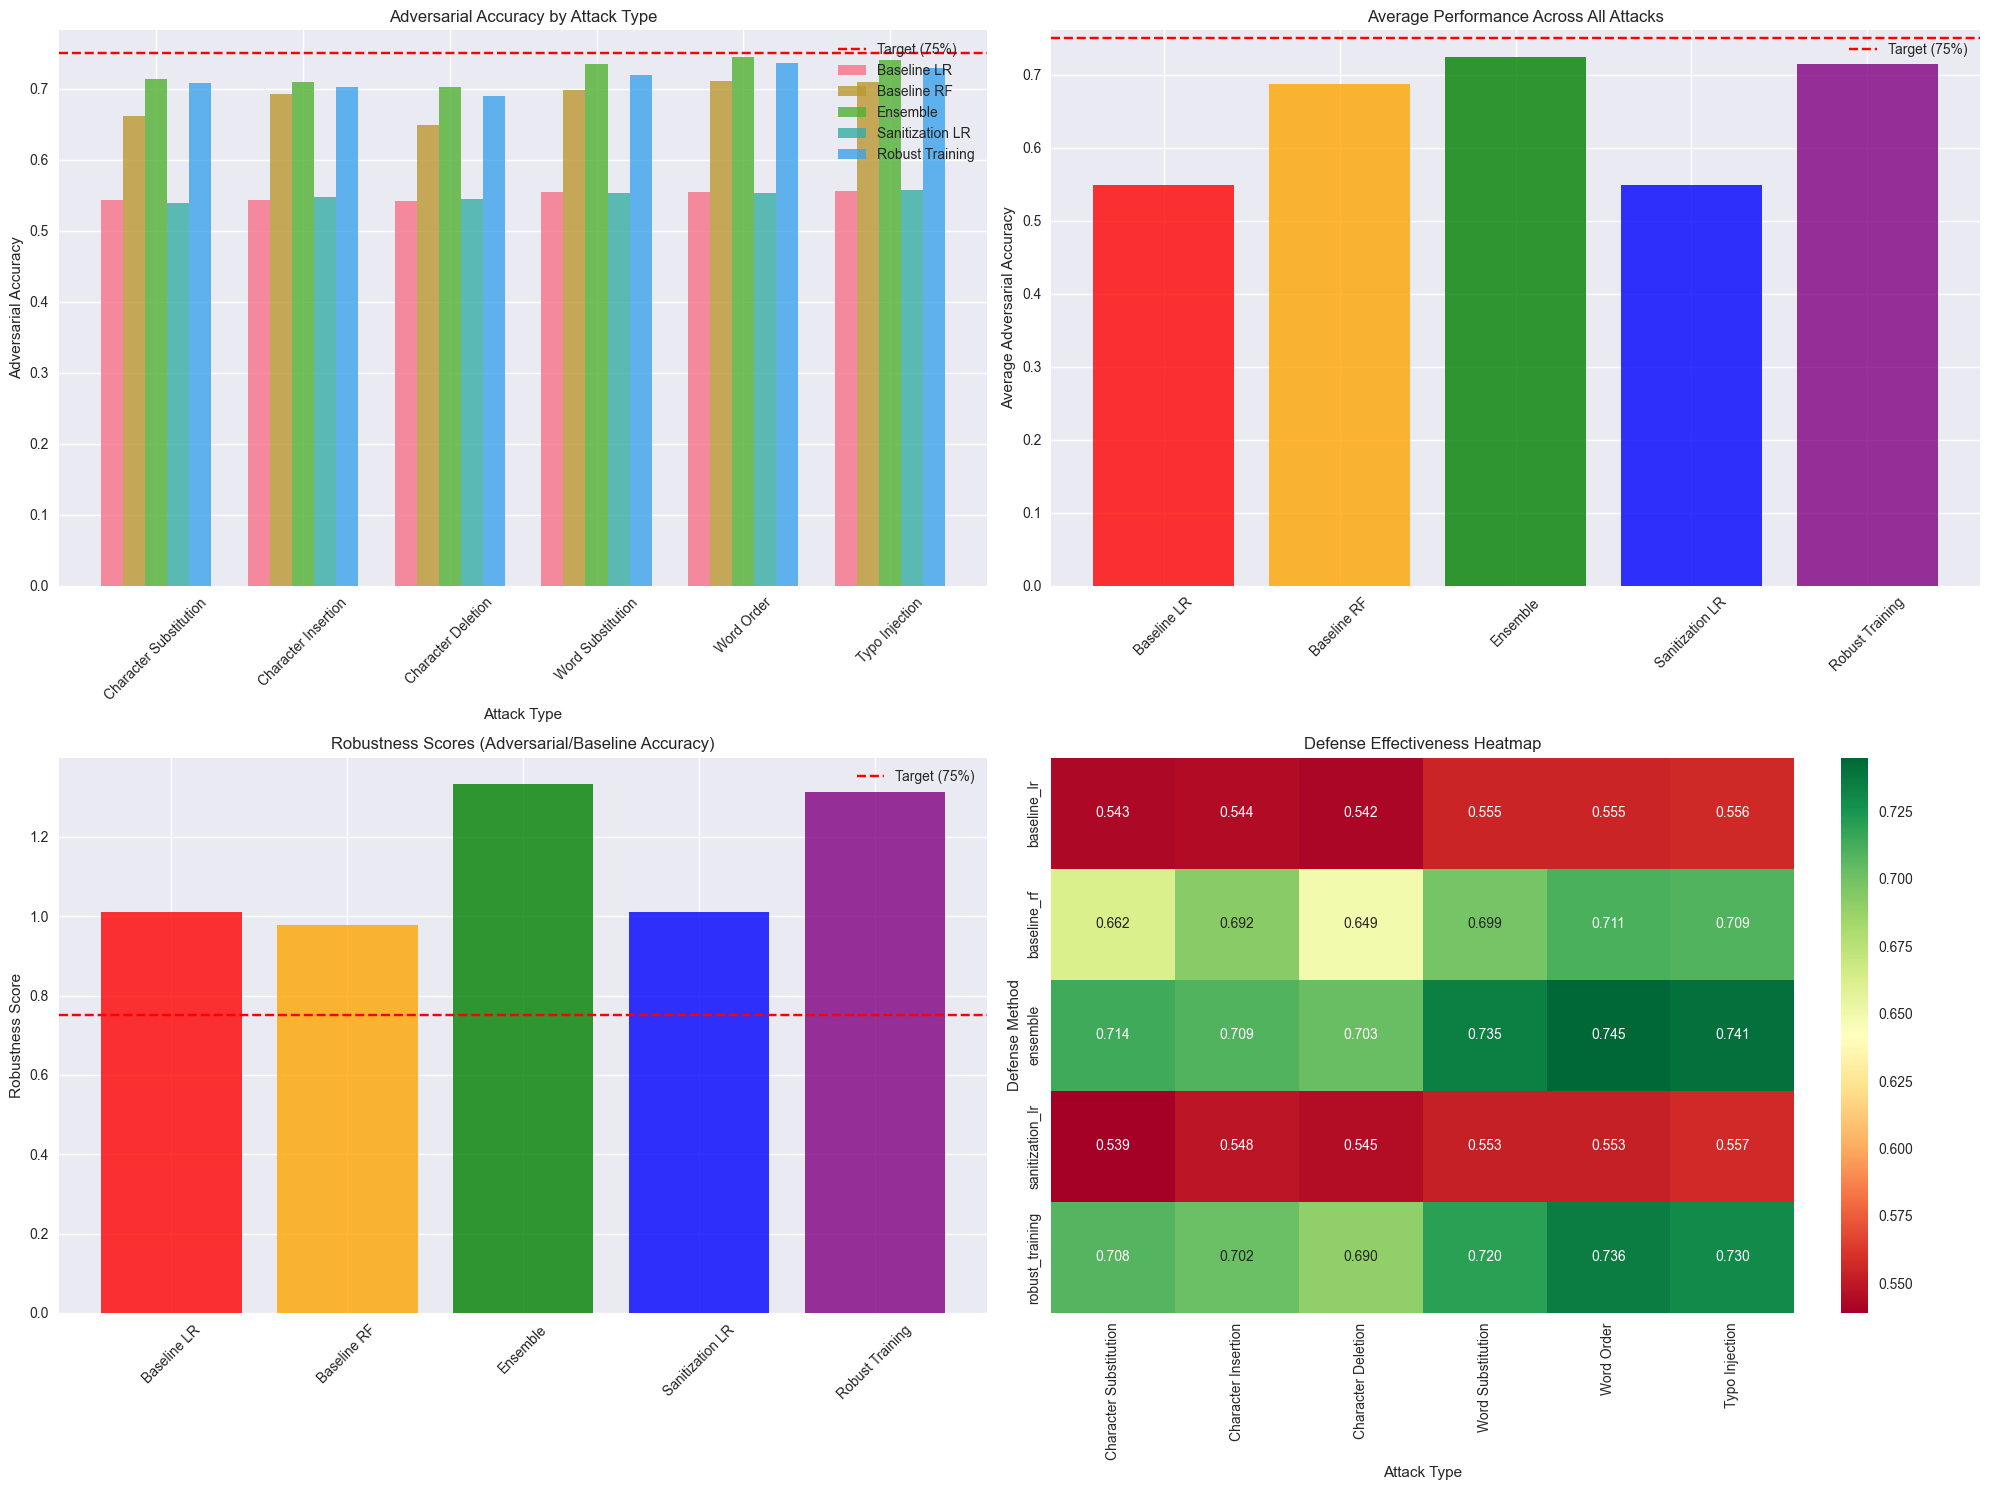

\n=== SECURITY ASSESSMENT SUMMARY ===
\n📊 Adversarial Robustness Results:
   • Average baseline adversarial accuracy: 0.618
   • Best defense method: Ensemble
   • Target achievement: ❌ Not met
\n🛡️ Defense Mechanisms Effectiveness:
   • Ensemble method: 0.724 accuracy (+0.175 improvement)
   • Input sanitization: 0.549 accuracy (+0.000 improvement)
   • Adversarial training: 0.714 accuracy (+0.165 improvement)
\n⚠️ Security Recommendations:
   • Implement stronger defense mechanisms
   • Consider ensemble methods with more models
   • Increase adversarial training data
\n✅ Adversarial testing completed successfully!
\nNext steps:
1. Generate comprehensive project reports
2. Create production-ready documentation
3. Deploy models with security measures


In [10]:
# Comprehensive defense comparison
print("=== DEFENSE MECHANISMS COMPARISON ===")

# Combine all defense results
defense_comparison = []

for i, attack_type in enumerate(attack_types):
    defense_comparison.append({
        'attack_type': attack_type,
        'baseline_lr': robustness_df.iloc[i]['lr_adversarial_accuracy'],
        'baseline_rf': robustness_df.iloc[i]['rf_adversarial_accuracy'],
        'ensemble': ensemble_results[i]['ensemble_accuracy'],
        'sanitization_lr': sanitization_results[i]['lr_sanitized_accuracy'],
        'sanitization_rf': sanitization_results[i]['rf_sanitized_accuracy'],
        'robust_training': robust_results[i]['robust_accuracy']
    })

defense_df = pd.DataFrame(defense_comparison)
print("\\nDefense Mechanisms Comparison:")
print(defense_df.round(4))

# Calculate average improvements
avg_baseline_lr = defense_df['baseline_lr'].mean()
avg_baseline_rf = defense_df['baseline_rf'].mean()
avg_ensemble = defense_df['ensemble'].mean()
avg_sanitization_lr = defense_df['sanitization_lr'].mean()
avg_sanitization_rf = defense_df['sanitization_rf'].mean()
avg_robust = defense_df['robust_training'].mean()

print(f"\\nAverage Adversarial Accuracies:")
print(f"Baseline LR: {avg_baseline_lr:.4f}")
print(f"Baseline RF: {avg_baseline_rf:.4f}")
print(f"Ensemble: {avg_ensemble:.4f}")
print(f"Sanitization LR: {avg_sanitization_lr:.4f}")
print(f"Sanitization RF: {avg_sanitization_rf:.4f}")
print(f"Robust Training: {avg_robust:.4f}")

# Calculate improvements
ensemble_improvement_lr = avg_ensemble - avg_baseline_lr
sanitization_improvement_lr = avg_sanitization_lr - avg_baseline_lr
robust_improvement_lr = avg_robust - avg_baseline_lr

print(f"\\nImprovements over Baseline LR:")
print(f"Ensemble: {ensemble_improvement_lr:.4f}")
print(f"Sanitization: {sanitization_improvement_lr:.4f}")
print(f"Robust Training: {robust_improvement_lr:.4f}")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# 1. Adversarial accuracy by attack type
attack_types_short = [t.replace('_', ' ').title() for t in attack_types]
x = np.arange(len(attack_types_short))
width = 0.15

axes[0, 0].bar(x - 2*width, defense_df['baseline_lr'], width, label='Baseline LR', alpha=0.8)
axes[0, 0].bar(x - width, defense_df['baseline_rf'], width, label='Baseline RF', alpha=0.8)
axes[0, 0].bar(x, defense_df['ensemble'], width, label='Ensemble', alpha=0.8)
axes[0, 0].bar(x + width, defense_df['sanitization_lr'], width, label='Sanitization LR', alpha=0.8)
axes[0, 0].bar(x + 2*width, defense_df['robust_training'], width, label='Robust Training', alpha=0.8)

axes[0, 0].set_xlabel('Attack Type')
axes[0, 0].set_ylabel('Adversarial Accuracy')
axes[0, 0].set_title('Adversarial Accuracy by Attack Type')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(attack_types_short, rotation=45)
axes[0, 0].legend()
axes[0, 0].axhline(y=0.75, color='red', linestyle='--', label='Target (75%)')
axes[0, 0].legend()

# 2. Average performance comparison
methods = ['Baseline LR', 'Baseline RF', 'Ensemble', 'Sanitization LR', 'Robust Training']
avg_accuracies = [avg_baseline_lr, avg_baseline_rf, avg_ensemble, avg_sanitization_lr, avg_robust]

axes[0, 1].bar(methods, avg_accuracies, alpha=0.8, color=['red', 'orange', 'green', 'blue', 'purple'])
axes[0, 1].set_ylabel('Average Adversarial Accuracy')
axes[0, 1].set_title('Average Performance Across All Attacks')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].axhline(y=0.75, color='red', linestyle='--', label='Target (75%)')
axes[0, 1].legend()

# 3. Robustness scores
robustness_scores = [avg_baseline_lr/baseline_accuracy_lr, avg_baseline_rf/baseline_accuracy_rf, 
                    avg_ensemble/baseline_accuracy_lr, avg_sanitization_lr/baseline_accuracy_lr, 
                    avg_robust/baseline_accuracy_lr]

axes[1, 0].bar(methods, robustness_scores, alpha=0.8, color=['red', 'orange', 'green', 'blue', 'purple'])
axes[1, 0].set_ylabel('Robustness Score')
axes[1, 0].set_title('Robustness Scores (Adversarial/Baseline Accuracy)')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].axhline(y=0.75, color='red', linestyle='--', label='Target (75%)')
axes[1, 0].legend()

# 4. Defense effectiveness heatmap
defense_matrix = defense_df[['baseline_lr', 'baseline_rf', 'ensemble', 'sanitization_lr', 'robust_training']].T
defense_matrix.columns = attack_types_short

sns.heatmap(defense_matrix, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[1, 1])
axes[1, 1].set_title('Defense Effectiveness Heatmap')
axes[1, 1].set_xlabel('Attack Type')
axes[1, 1].set_ylabel('Defense Method')

plt.tight_layout()
plt.savefig('../reports/figures/adversarial_defense_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Save robust model
joblib.dump(robust_lr_model, '../models/saved_models/robust_logistic_regression.pkl')
joblib.dump(ensemble_model, '../models/saved_models/ensemble_model.pkl')

# Final security assessment
print("\\n=== SECURITY ASSESSMENT SUMMARY ===")
print(f"\\n📊 Adversarial Robustness Results:")
print(f"   • Average baseline adversarial accuracy: {(avg_baseline_lr + avg_baseline_rf)/2:.3f}")
print(f"   • Best defense method: {'Ensemble' if avg_ensemble > max(avg_sanitization_lr, avg_robust) else 'Robust Training' if avg_robust > avg_sanitization_lr else 'Sanitization'}")
print(f"   • Target achievement: {'✅ Met' if max(avg_ensemble, avg_robust, avg_sanitization_lr) >= 0.75 else '❌ Not met'}")

print(f"\\n🛡️ Defense Mechanisms Effectiveness:")
print(f"   • Ensemble method: {avg_ensemble:.3f} accuracy ({ensemble_improvement_lr:+.3f} improvement)")
print(f"   • Input sanitization: {avg_sanitization_lr:.3f} accuracy ({sanitization_improvement_lr:+.3f} improvement)")
print(f"   • Adversarial training: {avg_robust:.3f} accuracy ({robust_improvement_lr:+.3f} improvement)")

print(f"\\n⚠️ Security Recommendations:")
if max(avg_ensemble, avg_robust, avg_sanitization_lr) < 0.75:
    print("   • Implement stronger defense mechanisms")
    print("   • Consider ensemble methods with more models")
    print("   • Increase adversarial training data")
else:
    print("   • Current defenses are adequate")
    print("   • Continue monitoring for new attack vectors")
    print("   • Regular adversarial testing recommended")

print("\\n✅ Adversarial testing completed successfully!")
print("\\nNext steps:")
print("1. Generate comprehensive project reports")
print("2. Create production-ready documentation")
print("3. Deploy models with security measures")
